In [1]:
# Import warnings filter 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Importing Dask packages
import dask.dataframe as dd
import dask.array as da

# Import other needed python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

import datetime
from datetime import date, timedelta

from scipy.integrate import ode

/Users/aetingu/opt/anaconda3/envs/covid/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import os
import requests
import io
import wget

#### Retrieving and combining daily Covid-19 data from github

In [3]:
stats = ['confirmed', 'deaths', 'recovered']
data = pd.DataFrame()
for i in stats:
    print("Getting:" + i)
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_" + i +"_global.csv"
    download = requests.get(url).content
    temp = pd.read_csv(io.StringIO(download.decode('utf-8')))
    temp['Status'] = i
    data = data.append(temp)

Getting:confirmed
Getting:deaths
Getting:recovered


In [4]:
data.Status.unique()

array(['confirmed', 'deaths', 'recovered'], dtype=object)

### Filtering the data for our select countries

In [5]:
countries = ['Turkey', 'Norway', 'United Kingdom']
co = pd.DataFrame()
for country in countries:
    temp = data[(data['Country/Region']== country) & (data['Province/State'].isnull())]
    co = co.append(temp)
co.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,Status
243,NaN,Turkey,38.9637,35.2433,0,0,0,0,0,0,...,363999,366208,368513,370832,373154,375367,377473,379775,382118.0,confirmed
243,NaN,Turkey,38.9637,35.2433,0,0,0,0,0,0,...,9874,9950,10027,10099,10177,10252,10326,10402,10481.0,deaths
230,NaN,Turkey,38.9637,35.2433,0,0,0,0,0,0,...,316008,317519,319181,320762,322465,323971,325486,327007,328824.0,recovered
197,NaN,Norway,60.4720,8.4689,0,0,0,0,0,0,...,18342,18666,19069,19564,20062,20331,20635,21339,21956.0,confirmed
197,NaN,Norway,60.4720,8.4689,0,0,0,0,0,0,...,279,280,280,281,282,282,282,282,282.0,deaths


In [6]:
co.drop(['Province/State'],axis=1, inplace=True)
co = pd.melt(co, id_vars=['Country/Region','Lat','Long','Status'], var_name='Dates', value_name='Metric').sort_values(['Country/Region','Status','Dates'],ascending=[True,True,True])
co['Dates'] = pd.to_datetime(co['Dates'])
co = co.pivot(index=(['Country/Region','Lat','Long','Dates']), columns=['Status'])['Metric'].reset_index()
co

Status,Country/Region,Lat,Long,Dates,confirmed,deaths,recovered
0,Norway,60.4720,8.4689,2020-01-22,0.0,0.0,0.0
1,Norway,60.4720,8.4689,2020-01-23,0.0,0.0,0.0
2,Norway,60.4720,8.4689,2020-01-24,0.0,0.0,0.0
3,Norway,60.4720,8.4689,2020-01-25,0.0,0.0,0.0
4,Norway,60.4720,8.4689,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...
856,United Kingdom,55.3781,-3.4360,2020-10-30,989745.0,46229.0,0.0
857,United Kingdom,55.3781,-3.4360,2020-10-31,1011660.0,46555.0,0.0
858,United Kingdom,55.3781,-3.4360,2020-11-01,1034914.0,46717.0,0.0
859,United Kingdom,55.3781,-3.4360,2020-11-02,1053864.0,46853.0,0.0


### Visualizing the data

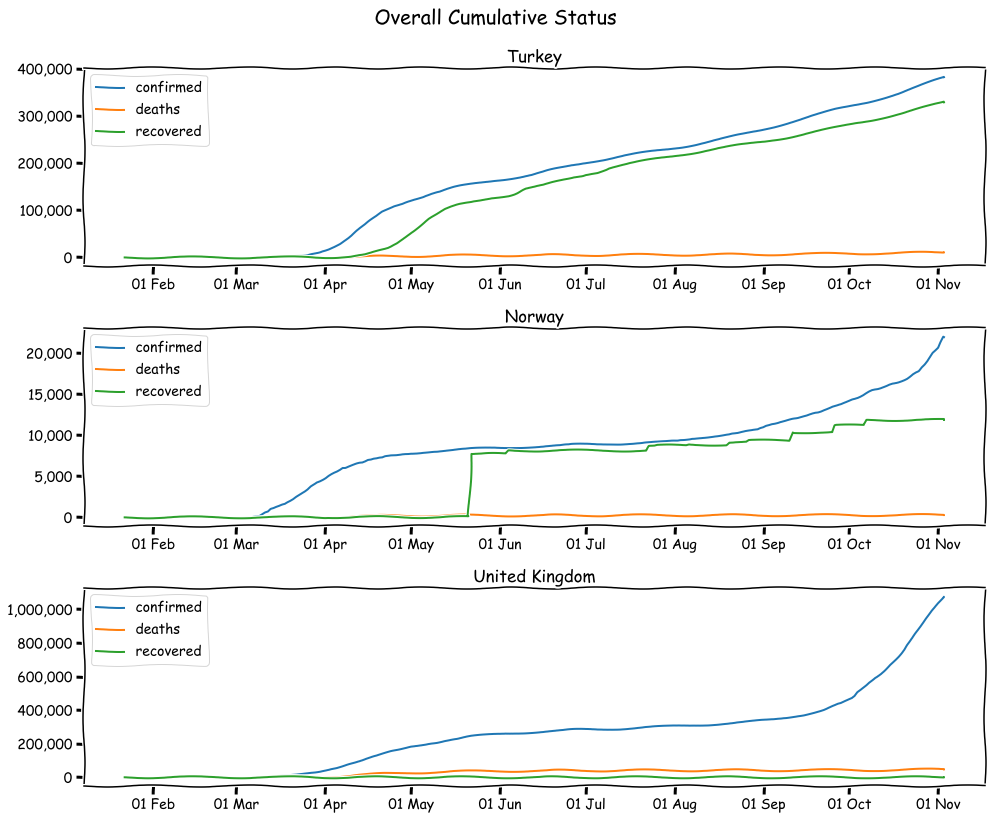

In [7]:
plt.xkcd()
fig, ax = plt.subplots(3,figsize=(14,12))
for i, country in enumerate(countries):
    temp = co[(co['Country/Region'] == country)]
    for stat in stats:
        ax[i].plot(temp['Dates'], temp[stat], label=stat)
        ax[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        ax[i].legend()
        ax[i].set_title(country)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Overall Cumulative Status', fontsize=20)

In [8]:
co_daily = co.copy()
co_daily['confirmed_daily'] = co_daily.groupby(['Country/Region'])['confirmed'].diff().fillna(0)
co_daily['recovered_daily'] = co_daily.groupby(['Country/Region'])['recovered'].diff().fillna(0)
co_daily['deaths_daily'] = co_daily.groupby(['Country/Region'])['deaths'].diff().fillna(0)

Text(0.5, 0.98, 'Daily Confirmed Cases')

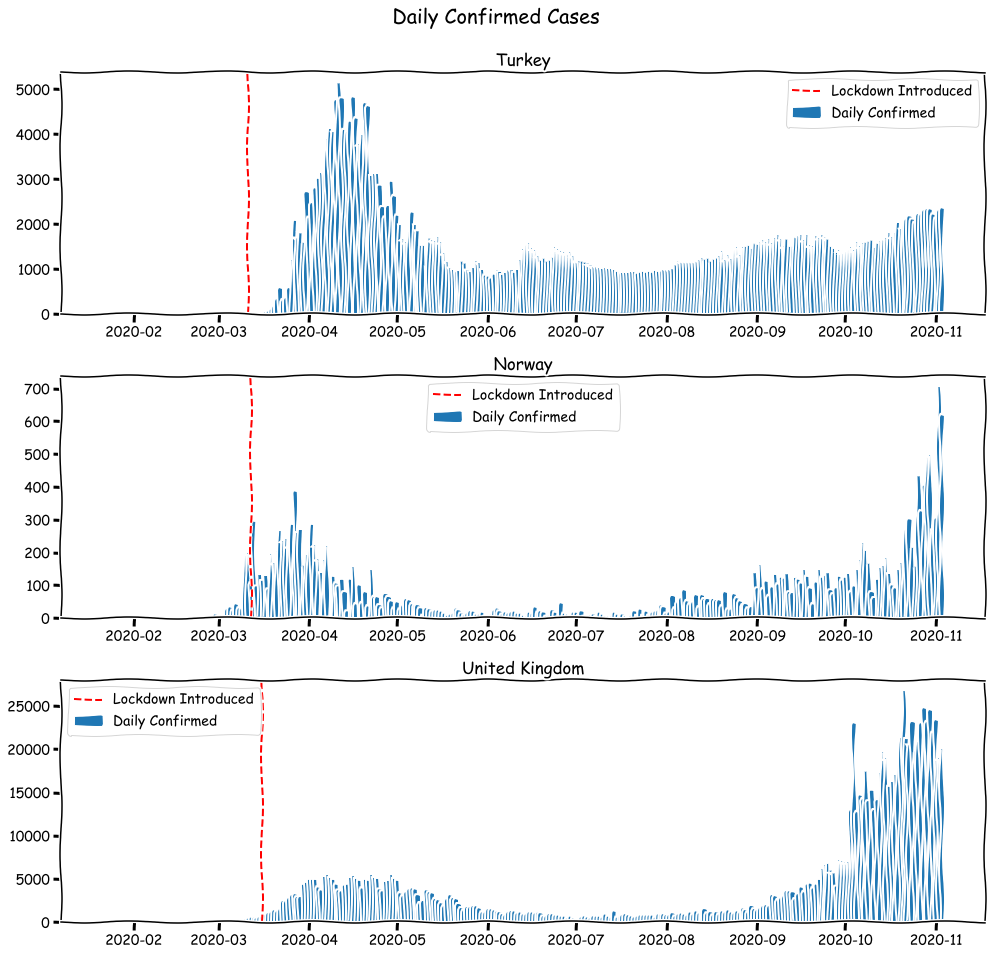

In [9]:
plt.xkcd()
#plt.rcdefaults()
lockdown = ['2020-03-11','2020-03-12','2020-03-16']
fig, ax = plt.subplots(3,figsize=(14,14))
for i, country in enumerate(countries):
    temp = co_daily[(co_daily['Country/Region'] == country)]
    ax[i].bar(temp['Dates'], temp['confirmed_daily'], label='Daily Confirmed')
    ax[i].set_title(country)
    ax[i].axvline(x=(datetime.datetime.strptime(lockdown[i],"%Y-%m-%d")),
                  linestyle='--', color='r', label = 'Lockdown Introduced')
    ax[i].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Daily Confirmed Cases', fontsize=20)



In [10]:
population = ['82','5','66']
co_comp = co.copy()
conditions = [(co_comp['Country/Region'] == 'Turkey'),
    (co_comp['Country/Region'] == 'Norway'),
    (co_comp['Country/Region'] == 'United Kingdom')]
co_comp['population'] = np.select(conditions, population)
co_comp['population'] = pd.to_numeric(co_comp['population'])
co_comp['confirmed_pmil'] = co_comp['confirmed']/co_comp['population']
co_comp['recovered_pmil'] = co_comp['recovered']/co_comp['population']
co_comp['deaths_pmil'] = co_comp['deaths']/co_comp['population']
co_comp.head()

Status,Country/Region,Lat,Long,Dates,confirmed,deaths,recovered,population,confirmed_pmil,recovered_pmil,deaths_pmil
0,Norway,60.472,8.4689,2020-01-22,0.0,0.0,0.0,5,0.0,0.0,0.0
1,Norway,60.472,8.4689,2020-01-23,0.0,0.0,0.0,5,0.0,0.0,0.0
2,Norway,60.472,8.4689,2020-01-24,0.0,0.0,0.0,5,0.0,0.0,0.0
3,Norway,60.472,8.4689,2020-01-25,0.0,0.0,0.0,5,0.0,0.0,0.0
4,Norway,60.472,8.4689,2020-01-26,0.0,0.0,0.0,5,0.0,0.0,0.0


In [11]:
co_comp.columns[8:]

Index(['confirmed_pmil', 'recovered_pmil', 'deaths_pmil'], dtype='object', name='Status')

Text(0.5, 0.98, 'Daily Confirmed Cases')

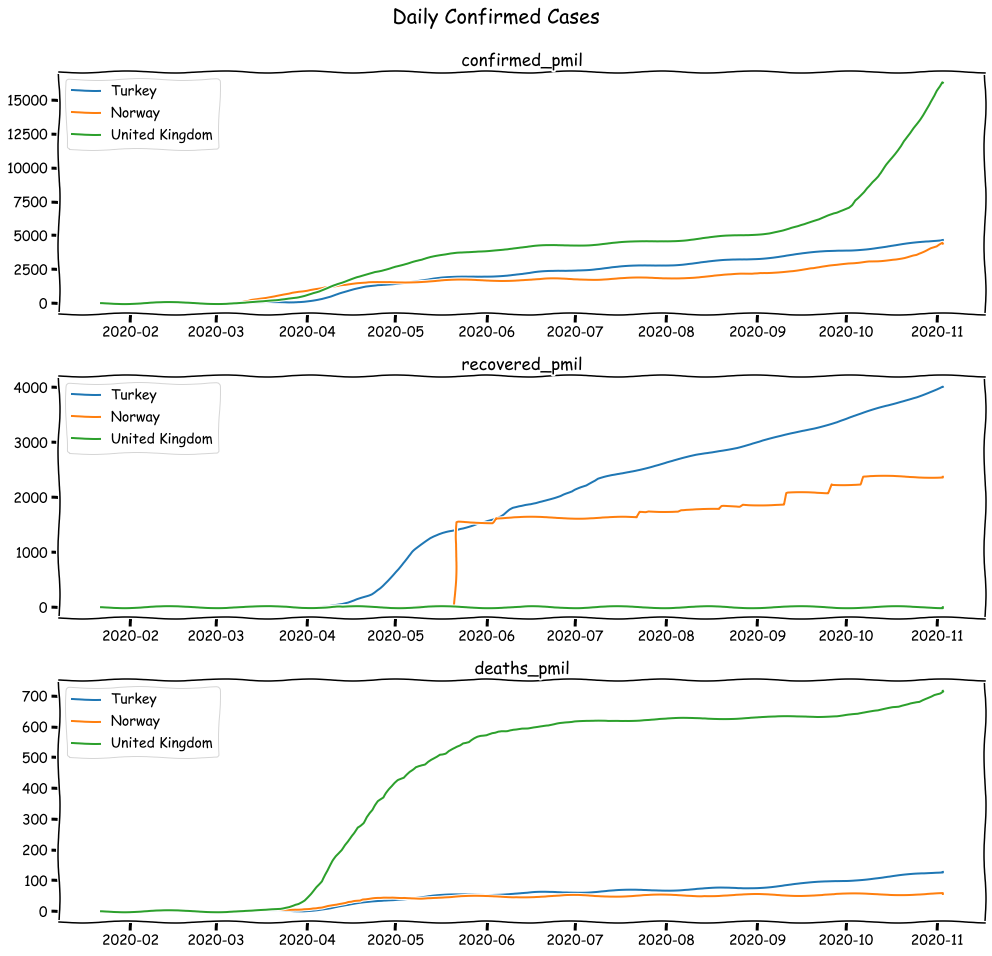

In [12]:
plt.xkcd()
#plt.rcdefaults()
lockdown = ['2020-03-11','2020-03-12','2020-03-16']
fig, ax = plt.subplots(nrows=3,figsize=(14,14))
for i, stat in enumerate(co_comp.columns[8:]):
    
    for country in countries:
        temp = co_comp[co_comp['Country/Region']==country]
        ax[i].plot(temp['Dates'], temp[stat], label=country)
        ax[i].legend()
        ax[i].set_title(stat)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Daily Confirmed Cases', fontsize=20)

#### Calculating R value

In [13]:
data_r = co_comp[['Country/Region','Dates','confirmed']]
R_calc = pd.DataFrame()
for country in data_r['Country/Region'].unique():
    temp = data_r[data_r['Country/Region'] == country]
    shift = temp.index[((temp['confirmed']-100).abs() == (temp['confirmed']-100).abs().min()).values.flatten()]
    rowno = shift[0]-temp.index[0]
    temp = temp.shift(-rowno).dropna().reset_index()
    temp.drop(columns=('index'), axis=1, inplace=True)
    R_calc = R_calc.append(temp)

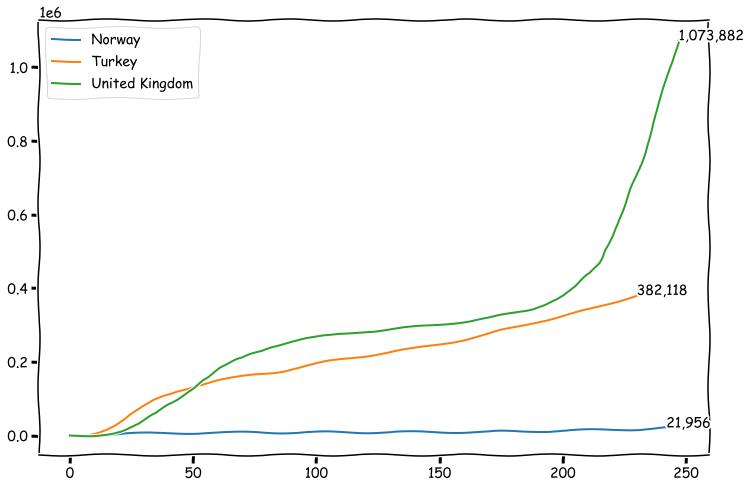

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
for country in R_calc['Country/Region'].unique():
    temp = R_calc[R_calc['Country/Region']==country]
    ax.plot(temp.index, temp['confirmed'], label=country)
    ax.legend()
    ax.text(max(temp.index),max(temp['confirmed']),"{:,.0f}".format(max(temp['confirmed'])))

In [15]:
"{:,.0f}".format(max(temp['confirmed']))

'1,073,882'

In [16]:
temp.shift(-rowno).dropna(inplace=True)

In [17]:
temp.shift(-rowno)

Status,Country/Region,Dates,confirmed
0,United Kingdom,2020-04-09,81498.0
1,United Kingdom,2020-04-10,85813.0
2,United Kingdom,2020-04-11,89390.0
3,United Kingdom,2020-04-12,92885.0
4,United Kingdom,2020-04-13,97068.0
...,...,...,...
243,NaN,NaT,NaN
244,NaN,NaT,NaN
245,NaN,NaT,NaN
246,NaN,NaT,NaN


### SIR Model

#### Assuming disease is non-fatal

In [18]:
def get_beta_gamma(R=5,recovery_time=14):
    gamma = 1./recovery_time
    beta = R*gamma
    return beta, gamma 
beta, gamma = get_beta_gamma()
print("beta = {}\ngamma = {}".format(beta,gamma))

beta = 0.3571428571428571
gamma = 0.07142857142857142


In [19]:
i0 = 1e-7
r0 = 0
s0 = 1 - i0

$$ \frac{dU}{dt} = f(t,U) $$
in our case;
$$ U = (s,i,r) $$
so:
$$ f (t, U) = (−βsi, βsi − γsi, γi) $$

In [20]:
num_times = 270 # simulate for half a year 
times = np.arange(num_times)
Us = np.empty((num_times,3)) 
Us[0] = np.array([s0,i0,r0])

In [21]:

def rhs(t, U, beta, gamma): 
    s,i,r = U[0],U[1],U[2]
    return np.array([-beta*s*i,beta*s*i-gamma*i,gamma*i])

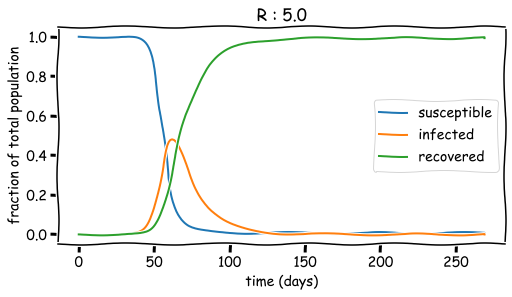

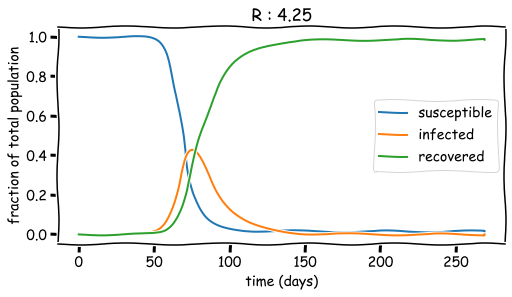

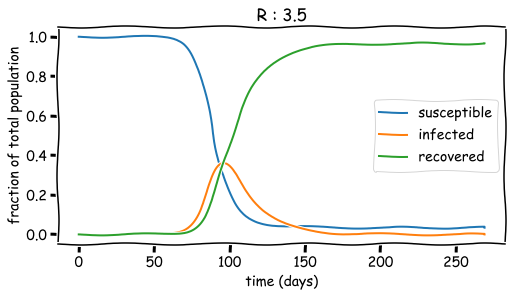

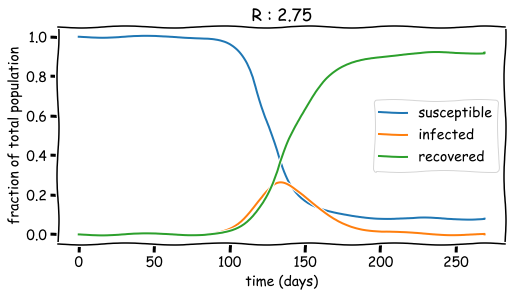

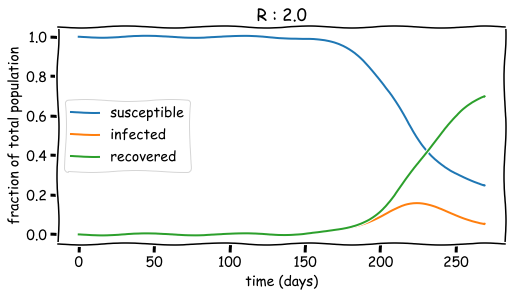

In [22]:
for rate in np.linspace(5,2,5):
    integrator = ode(rhs)
    beta,gamma = get_beta_gamma(R=rate,recovery_time=14) 
    integrator.set_initial_value(Us[0],0) 
    integrator.set_f_params(beta,gamma)
    for i in range(len(times)-1): 
        t = times[i+1]
        integrator.integrate(t) 
        Us[i+1] = integrator.y
    s,i,r = Us[:,0],Us[:,1],Us[:,2]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(times,s,label='susceptible') 
    ax.plot(times,i,label='infected') 
    ax.plot(times,r,label='recovered') 
    ax.legend()
    ax.set_title('R : '+str(rate))
    ax.set_xlabel('time (days)') 
    ax.set_ylabel('fraction of total population')

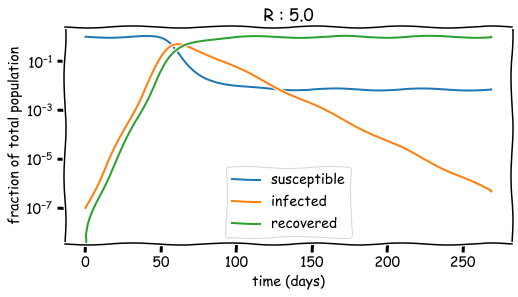

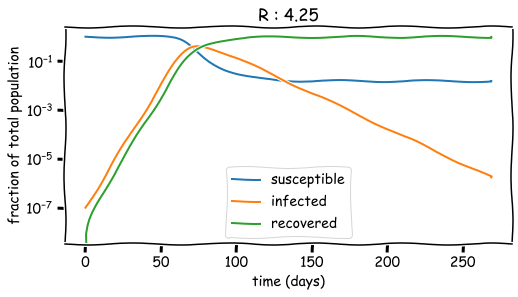

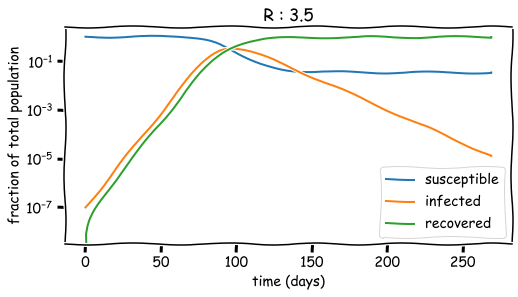

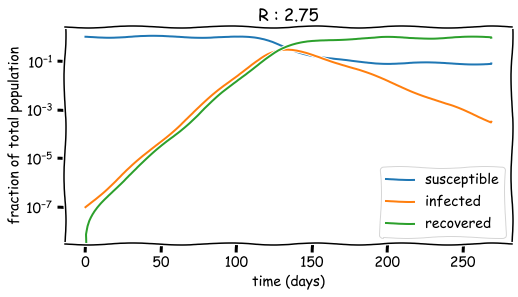

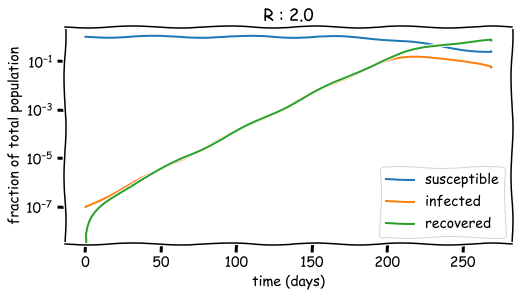

In [23]:
for rate in np.linspace(5,2,5):
    integrator = ode(rhs)
    beta,gamma = get_beta_gamma(R=rate,recovery_time=14) 
    integrator.set_initial_value(Us[0],0) 
    integrator.set_f_params(beta,gamma)
    for i in range(len(times)-1): 
        t = times[i+1]
        integrator.integrate(t) 
        Us[i+1] = integrator.y
    s,i,r = Us[:,0],Us[:,1],Us[:,2]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.semilogy(times,s,label='susceptible') 
    ax.plot(times,i,label='infected') 
    ax.plot(times,r,label='recovered') 
    ax.legend()
    ax.set_title('R : '+str(rate))
    ax.set_xlabel('time (days)') 
    ax.set_ylabel('fraction of total population')

### SIRD Model

$$ R_{1} $$ is the fraction of people with the disease and die.  For Covid 19 this is somewhere around 0.03

In [24]:
R1 = 3/100
d0 = 0 # no body has died yet.

In [25]:
num_times = 270 # simulate for half a year 
times = np.arange(num_times)
Us = np.empty((num_times,4)) 
Us[0] = np.array([s0,i0,r0,d0])

In [26]:
def rhs(t, U, beta, gamma, sigma): 
    s,i,r,d = U[0],U[1],U[2],U[3]
    return np.array([-beta*s*i, beta*s*i-(gamma+sigma)*i,gamma*i,sigma*i ])

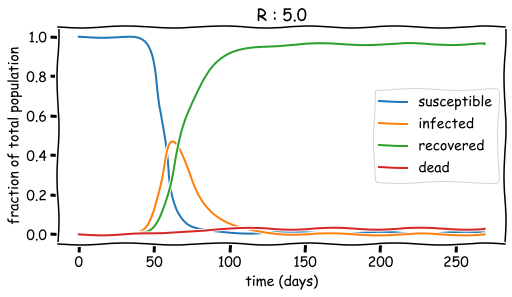

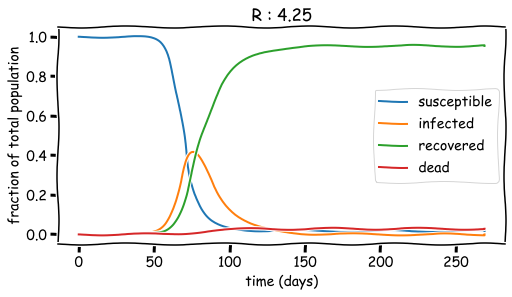

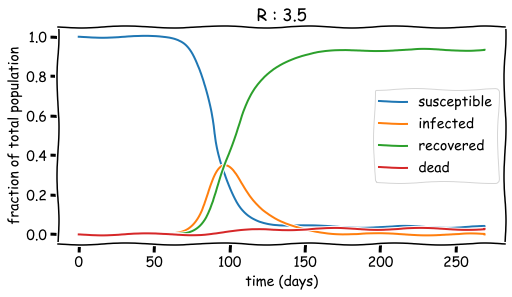

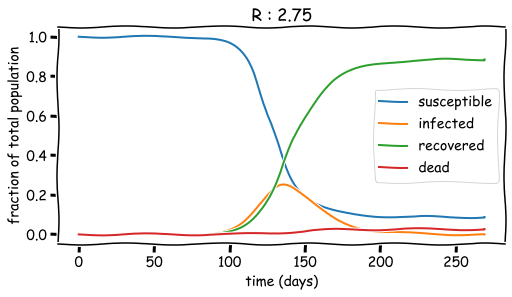

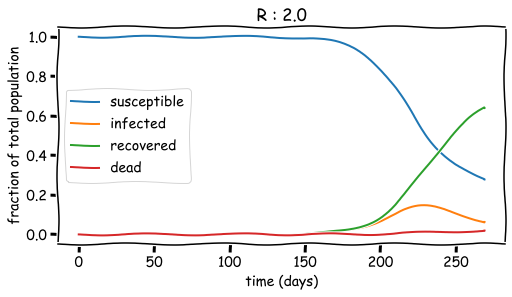

In [27]:
for rate in np.linspace(5,2,5):
    integrator = ode(rhs)
    # set initial conditions and parameters
    beta,gamma = get_beta_gamma(R=rate,recovery_time=14) 
    sigma = R1*gamma 
    integrator.set_initial_value(Us[0],0) 
    integrator.set_f_params(beta,gamma,sigma)
    for i in range(len(times)-1): 
        t = times[i+1]
        integrator.integrate(t) 
        Us[i+1] = integrator.y
    s,i,r,d = Us[:,0],Us[:,1],Us[:,2],Us[:,3]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(times,s,label='susceptible') 
    ax.plot(times,i,label='infected') 
    ax.plot(times,r,label='recovered') 
    ax.plot(times,d,label='dead') 
    ax.legend() 
    ax.set_title('R : '+str(rate))
    ax.set_xlabel('time (days)') 
    ax.set_ylabel('fraction of total population')

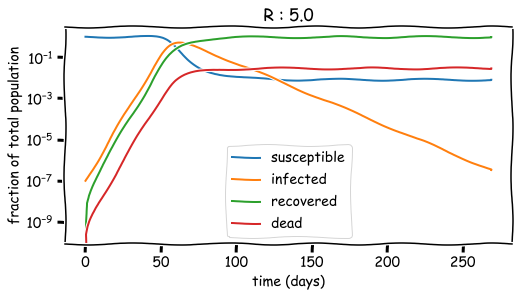

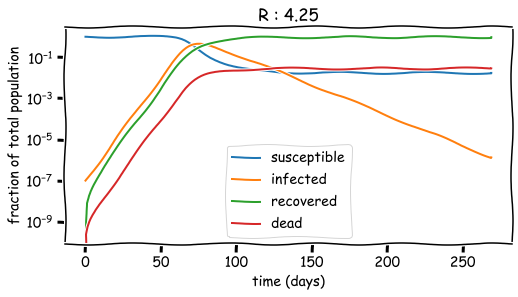

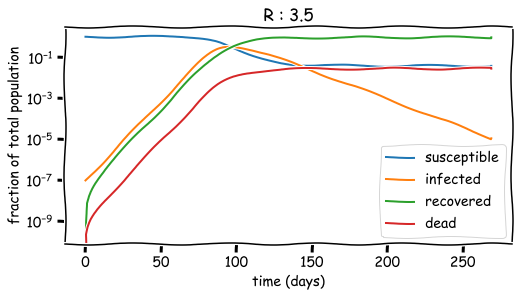

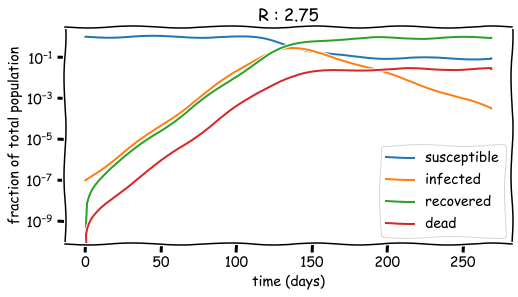

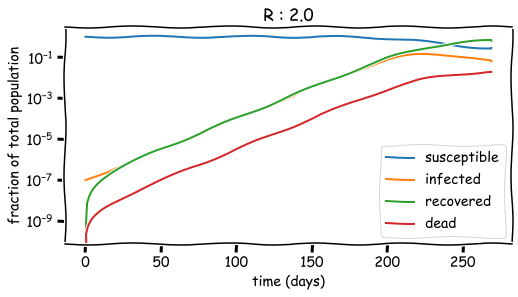

In [28]:
for rate in np.linspace(5,2,5):
    integrator = ode(rhs)
    # set initial conditions and parameters
    beta,gamma = get_beta_gamma(R=rate,recovery_time=14) 
    sigma = R1*gamma 
    integrator.set_initial_value(Us[0],0) 
    integrator.set_f_params(beta,gamma,sigma)
    for i in range(len(times)-1): 
        t = times[i+1]
        integrator.integrate(t) 
        Us[i+1] = integrator.y
    s,i,r,d = Us[:,0],Us[:,1],Us[:,2],Us[:,3]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.semilogy(times,s,label='susceptible') 
    ax.plot(times,i,label='infected') 
    ax.plot(times,r,label='recovered') 
    ax.plot(times,d,label='dead') 
    ax.legend() 
    ax.set_title('R : '+str(rate))
    ax.set_xlabel('time (days)') 
    ax.set_ylabel('fraction of total population')

In [29]:
df = co_daily.iloc[:,np.r_[0,3,7:10]]
TR = df[df['Country/Region']=='Turkey']
TR['active_daily'] = TR['confirmed_daily']-TR['recovered_daily']-TR['deaths_daily']
TR.reset_index(inplace=True)
TR = TR.drop(columns=['index'], axis=1)
TR.head()

/Users/aetingu/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Status,Country/Region,Dates,confirmed_daily,recovered_daily,deaths_daily,active_daily
0,Turkey,2020-01-22,0.0,0.0,0.0,0.0
1,Turkey,2020-01-23,0.0,0.0,0.0,0.0
2,Turkey,2020-01-24,0.0,0.0,0.0,0.0
3,Turkey,2020-01-25,0.0,0.0,0.0,0.0
4,Turkey,2020-01-26,0.0,0.0,0.0,0.0


In [30]:
X = TR.index.values
y = TR.confirmed_daily.values

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [33]:
X_train

array([175, 207,  48,  16, 107, 227, 216, 195,  14, 272,  33, 213, 124,
        53, 179, 269,  85,  80, 115, 240, 243, 142, 199,   4, 183, 153,
         8,  18, 284, 137, 222, 211, 144, 286, 112, 126,  65,  30, 245,
       277,  57, 231,  98,  89, 196, 283,  71, 208,  67, 127,  70, 141,
       170,  74, 193, 265, 180,  39, 270, 260, 212,  38, 116,  97, 225,
       155, 259, 248, 138, 218,  25,  13, 145, 253, 174,  58, 202, 171,
        64, 209, 205,  52, 251,  34,  78, 120, 276, 167, 177,  69, 173,
        28, 135, 131, 255, 165, 186,  42,  23,  91, 214, 182,  87, 281,
       100, 241,  94, 261,  31, 190, 191,  93,  45, 230, 108, 105, 149,
        29, 242, 109, 163, 122,  27, 104,  60, 146,  83, 266, 194, 125,
       166, 224, 223, 189, 151,   0, 236, 237, 282,  88, 204,  77,  12,
       161, 123,  41, 113,  95, 274,  11, 114,  75, 172,   1, 219, 181,
        96, 268,   5, 187, 178, 154,  22,  19,  99, 169, 239,  21, 160,
        73,  17,  62, 249, 228, 238, 229,  47, 250,  79, 273,  2

In [34]:
y_train.reshape(1,-1)

array([[9.470e+02, 1.192e+03, 0.000e+00, 0.000e+00, 1.848e+03, 1.673e+03,
        1.502e+03, 1.083e+03, 0.000e+00, 1.894e+03, 0.000e+00, 1.309e+03,
        9.870e+02, 1.000e+00, 9.240e+02, 1.723e+03, 4.801e+03, 5.138e+03,
        1.610e+03, 1.771e+03, 1.743e+03, 1.195e+03, 1.172e+03, 0.000e+00,
        9.130e+02, 1.268e+03, 0.000e+00, 0.000e+00, 2.106e+03, 9.140e+02,
        1.587e+03, 1.412e+03, 1.562e+03, 2.343e+03, 1.639e+03, 1.035e+03,
        2.069e+03, 0.000e+00, 1.767e+03, 2.017e+03, 9.400e+01, 1.673e+03,
        2.936e+03, 4.674e+03, 1.178e+03, 2.213e+03, 2.456e+03, 1.233e+03,
        1.815e+03, 1.182e+03, 2.148e+03, 9.870e+02, 1.003e+03, 3.135e+03,
        9.870e+02, 1.632e+03, 9.310e+02, 0.000e+00, 1.815e+03, 1.615e+03,
        1.203e+03, 0.000e+00, 1.368e+03, 2.392e+03, 1.642e+03, 1.458e+03,
        1.581e+03, 1.511e+03, 9.890e+02, 1.491e+03, 0.000e+00, 0.000e+00,
        1.592e+03, 1.407e+03, 9.920e+02, 1.670e+02, 1.183e+03, 1.016e+03,
        1.196e+03, 1.263e+03, 1.226e+0

In [35]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='poly')
svr_reg.fit(X_train.reshape(-1,1), y_train)

SVR(kernel='poly')

In [36]:
prediction = svr_reg.predict(X_test.reshape(-1,1))

In [37]:
comparison = pd.DataFrame({'Real':y_test, 'Prediction':prediction})

In [38]:
print(comparison)

      Real   Prediction
0   1459.0   930.284860
1   1256.0  1272.554695
2      0.0   758.263941
3   1527.0  1521.776534
4      0.0   758.244232
..     ...          ...
82  1374.0   994.735225
83  1502.0  1828.508806
84  1612.0  1437.368285
85   867.0   896.657442
86  1158.0   852.472132

[87 rows x 2 columns]
